In [ ]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 60% !important; }</style>"))

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
np.random.seed(seed)
import logging
import random
random.seed(seed)
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
#from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import cv2
from google.colab.patches import cv2_imshow


2.14.0


##Load data

In [ ]:
data = np.load('/content/gdrive/My Drive/AN2DL_HW1/public_data.npz', allow_pickle=True)
X = data.get('data')
X = X/255
label = data.get('labels')
label = label == 'healthy'

out_1 = X[label == 0,:,:,:][20] # shrek
out_2 = X[label == 1,:,:,:][202] # Trol
X_filtered = []
label_filtered = []
for i in range(X.shape[0]):
    if ((X[i,:,:,:] == out_1).sum() < 7000) & ((X[i,:,:,:] == out_2).sum() < 7000):
        X_filtered.append(X[i,:,:,:])
        label_filtered.append(label[i])
X_filtered = np.array(X_filtered)
label_filtered = np.array(label_filtered)

X = X_filtered
label = label_filtered

y = tfk.utils.to_categorical(label,len(np.unique(label)))
del X_filtered,label_filtered

In [ ]:
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=.02, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=.02, stratify=np.argmax(y,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
#print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
class_weights = compute_class_weight('balanced', classes=np.unique(label), y=label)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

X_train shape: (4903, 96, 96, 3), y_train shape: (4903, 2)
X_val shape: (101, 96, 96, 3), y_val shape: (101, 2)


In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 128
epochs = 300

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: (2,), Batch Size: 128, Epochs: 300


In [ ]:
model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
#tfk.utils.plot_model(model, show_shapes=True)

473176280/473176280 [==============================] - 22s 0us/step


In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
model.trainable = False

# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=input_shape)

# Create augmentation

preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomRotation(1),
        tfkl.RandomZoom(height_factor = 0.25,width_factor = 0.25),
        tf.keras.layers.RandomTranslation(0.25,0.25),
        tf.keras.layers.RandomContrast(0.25)
], name='preprocessing')(inputs)

# Connect MobileNetV2 to the input
x = model(preprocessing)
# Add a Dense layer with 2 units and softmax activation as the classifier



outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.legacy.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-l (Function  (None, 1280)              117746848 
 al)                                                             
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 117749410 (449.18 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 117746848 (449.17 MB)
_________________________________________________________________


In [ ]:
# Train the model
with tf.device('gpu'):
    history = model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 256,
    epochs = 1000,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=200, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(factor=0.9)],
    class_weight = class_weight_dict
).history

Epoch 1/1000
20/20 [==============================] - 67s 1s/step - loss: 0.6897 - accuracy: 0.5352 - val_loss: 0.6651 - val_accuracy: 0.5644 - lr: 0.0010
Epoch 2/1000
20/20 [==============================] - 11s 576ms/step - loss: 0.6472 - accuracy: 0.6400 - val_loss: 0.6428 - val_accuracy: 0.5941 - lr: 0.0010
Epoch 3/1000
20/20 [==============================] - 11s 569ms/step - loss: 0.6216 - accuracy: 0.6875 - val_loss: 0.6058 - val_accuracy: 0.6733 - lr: 0.0010
Epoch 4/1000
20/20 [==============================] - 12s 577ms/step - loss: 0.6076 - accuracy: 0.6992 - val_loss: 0.5864 - val_accuracy: 0.6931 - lr: 0.0010
Epoch 5/1000
20/20 [==============================] - 12s 579ms/step - loss: 0.5918 - accuracy: 0.7039 - val_loss: 0.5667 - val_accuracy: 0.6931 - lr: 0.0010
Epoch 6/1000
20/20 [==============================] - 12s 579ms/step - loss: 0.5818 - accuracy: 0.7087 - val_loss: 0.5543 - val_accuracy: 0.7030 - lr: 0.0010
Epoch 7/1000
20/20 [==============================] - 1

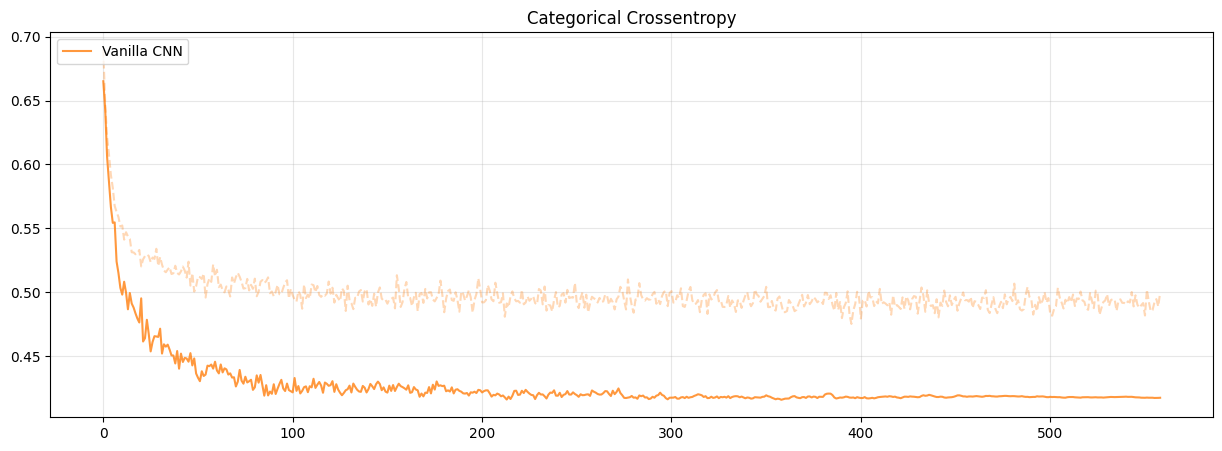

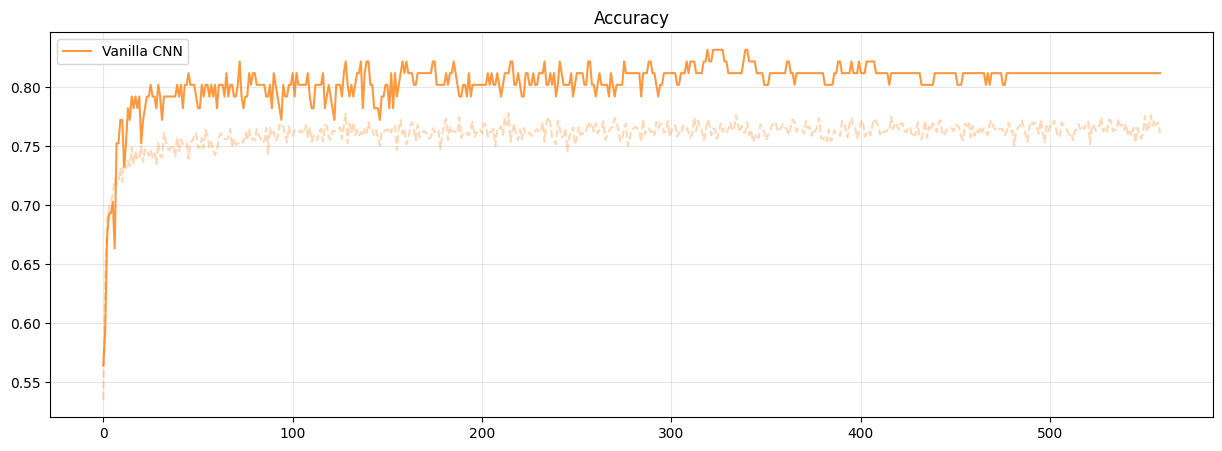

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save('/content/gdrive/My Drive/AN2DL_HW1/big_02_pre')
del model

In [ ]:
# Re-load the model after transfer learning
name = 'efficientnetv2-l'
model = tfk.models.load_model('/content/gdrive/My Drive/AN2DL_HW1/big_02_pre')
model.summary()
model.get_layer(name).trainable = True
for i, layer in enumerate(model.get_layer(name).layers):
   print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-l (Function  (None, 1280)              117746848 
 al)                                                             
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 117749410 (449.18 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 117746848 (449.17 MB)
_________________________________________________________________
0 input_1 True
1 rescaling True
2 stem_conv True
3 stem_bn True
4 stem_activati

In [ ]:
N = 900
for i, layer in enumerate(model.get_layer(name).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer(name).layers[N:]):
  layer.trainable=True
for i, layer in enumerate(model.get_layer(name).layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block1c_project_conv False
15 block1c_project_bn False
16 block1c_project_activation False
17 block1c_drop False
18 block1c_add False
19 block1d_project_conv False
20 block1d_project_bn False
21 block1d_project_activation False
22 block1d_drop False
23 block1d_add False
24 block2a_expand_conv False
25 block2a_expand_bn False
26 block2a_expand_activation False
27 block2a_project_conv False
28 block2a_project_bn False
29 block2b_expand_conv False
30 block2b_expand_bn False
31 block2b_expand_activation False
32 block2b_project_conv False
33 block2b_project_bn False
34 block2b_drop False
35 block2b_add False
36 block2c_expand_conv False
37 block2c_expand

In [ ]:
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.legacy.Adam(1e-5), metrics='accuracy')

In [ ]:
# Train the model
with tf.device('gpu'):
    history = model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 128,
    epochs = 1000,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=150, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(factor=0.9)],
    class_weight = class_weight_dict
).history

Epoch 1/1000
39/39 [==============================] - 56s 622ms/step - loss: 0.6050 - accuracy: 0.6690 - val_loss: 0.5459 - val_accuracy: 0.7129 - lr: 1.0000e-05
Epoch 2/1000
39/39 [==============================] - 16s 414ms/step - loss: 0.5668 - accuracy: 0.7075 - val_loss: 0.5220 - val_accuracy: 0.7228 - lr: 1.0000e-05
Epoch 3/1000
39/39 [==============================] - 16s 420ms/step - loss: 0.5396 - accuracy: 0.7312 - val_loss: 0.5174 - val_accuracy: 0.7426 - lr: 1.0000e-05
Epoch 4/1000
39/39 [==============================] - 17s 426ms/step - loss: 0.5083 - accuracy: 0.7502 - val_loss: 0.4701 - val_accuracy: 0.7525 - lr: 1.0000e-05
Epoch 5/1000
39/39 [==============================] - 16s 423ms/step - loss: 0.5064 - accuracy: 0.7495 - val_loss: 0.4399 - val_accuracy: 0.7624 - lr: 1.0000e-05
Epoch 6/1000
39/39 [==============================] - 17s 424ms/step - loss: 0.4961 - accuracy: 0.7575 - val_loss: 0.4202 - val_accuracy: 0.7624 - lr: 1.0000e-05
Epoch 7/1000
39/39 [========

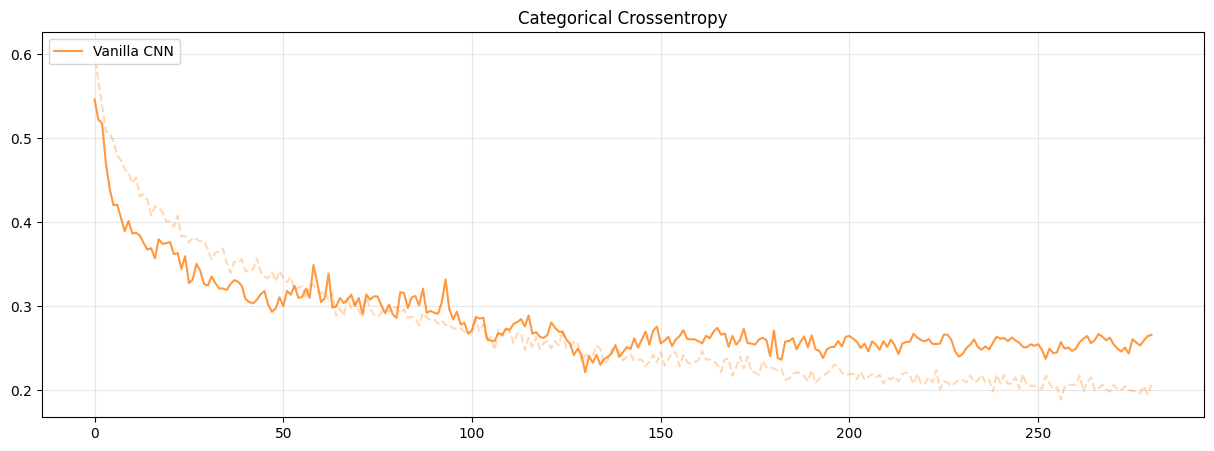

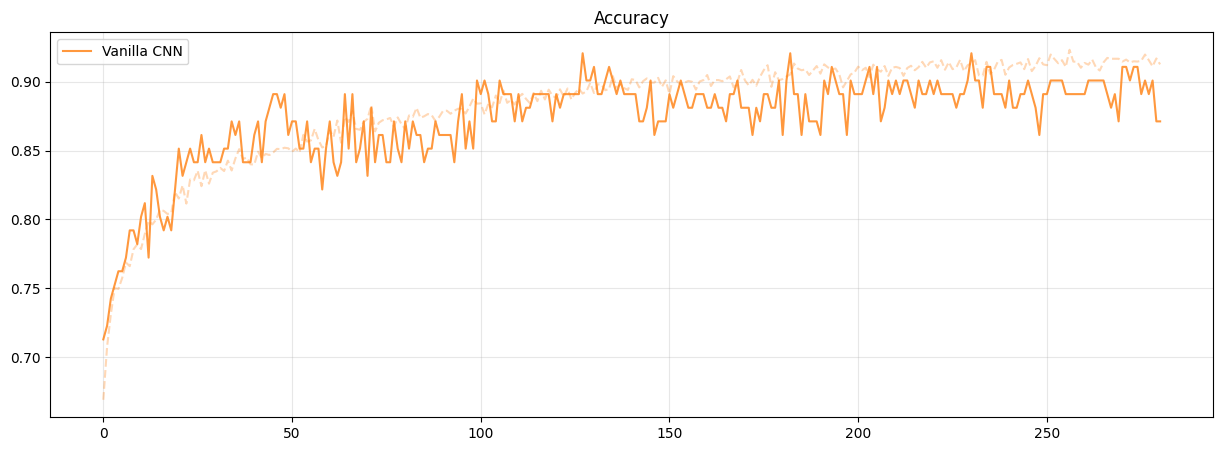

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save('/content/gdrive/My Drive/AN2DL_HW1/big_02')

# Predict labels for the entire test set
predictions = model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(5))
print('Precision:', precision.round(5))
print('Recall:', recall.round(5))
print('F1:', f1.round(5))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()